In [40]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.distributions as dist
import torch
import copy
import matplotlib.pyplot as plt
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import Callback
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from scripts.utils import ScaleData, train_keys
from scripts.AutoEncoder import Encoder, Decoder, AutoEncoderDataset
from tqdm import tqdm

import itertools
import seaborn as sns
#%matplotlib notebook

In [2]:
device = torch.device("cpu")

In [3]:
def ELBO(encoder, decoder, X):
        # calculate the ELBO loss
        q_z_given_x = encoder.forward(X)

        q_samples = q_z_given_x.rsample()

        ones = torch.ones(3)
        zeros = torch.zeros(3)
        
#         if torch.cuda.is_available():
#             ones.cuda()
#             zeros.cuda()
#             q_samples.cuda()
        
        latent_prior = dist.Normal(zeros, ones)
             
        log_p_z = latent_prior.log_prob(q_samples).sum(-1)

        log_q_z_given_x = q_z_given_x.log_prob(q_samples).sum(-1)

        log_p_x_given_z = decoder.forward(q_samples).log_prob(X).sum(dim=1)
        
        ELBO = log_p_x_given_z + log_p_z - log_q_z_given_x

        return ELBO

In [4]:
encoder = Encoder(3, 15, VAE = True)
decoder = Decoder(3, 15, VAE = True) 

In [5]:
train_data_path = "/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data_clipped.pkl"
train_data = AutoEncoderDataset(train_data_path, columns = train_keys, train = True)
train_data.data = train_data.data.sample(10_000)
train_data.scale()

train_loader = DataLoader(train_data, shuffle = True, batch_size = 1048)

valid_data_path = "/share/rcifdata/jbarr/UKAEAGroupProject/data/valid_data_clipped.pkl"
valid_data = AutoEncoderDataset(valid_data_path, columns = train_keys, train = True)
valid_data.data = valid_data.data.sample(10_000)
valid_data.scale()

valid_loader = DataLoader(valid_data, shuffle = True, batch_size = 1048)

In [6]:
# if torch.cuda.is_available():
#     encoder = encoder.cuda()
#     decoder = decoder.cuda() 

opt_vae = torch.optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()))
N_epochs = 50 # Note that you may want to run more than 10 epochs!
for epoch in range(N_epochs):
    train_loss = 0.0
    for X in train_loader:
#         if torch.cuda.is_available():
#             X = X.cuda()

        opt_vae.zero_grad()
        loss = -ELBO(encoder, decoder, X).mean()
        loss.backward()
        opt_vae.step()
        train_loss += loss.item() * X.shape[0] / len(train_data)
    print("Epoch %d, train loss = %0.4f" % (epoch, train_loss));

Epoch 0, train loss = 23.0660
Epoch 1, train loss = 22.7368
Epoch 2, train loss = 22.5549
Epoch 3, train loss = 22.2378
Epoch 4, train loss = 22.2154
Epoch 5, train loss = 22.1225
Epoch 6, train loss = 21.9892
Epoch 7, train loss = 21.8510
Epoch 8, train loss = 21.7281
Epoch 9, train loss = 21.7081
Epoch 10, train loss = 22.2431
Epoch 11, train loss = 21.5945
Epoch 12, train loss = 21.5326
Epoch 13, train loss = 21.3560
Epoch 14, train loss = 21.5285
Epoch 15, train loss = 21.5049
Epoch 16, train loss = 21.4370
Epoch 17, train loss = 21.2046
Epoch 18, train loss = 21.2361
Epoch 19, train loss = 21.1599
Epoch 20, train loss = 21.2057
Epoch 21, train loss = 21.0855
Epoch 22, train loss = 21.0598
Epoch 23, train loss = 20.9354
Epoch 24, train loss = 20.7252
Epoch 25, train loss = 21.0491
Epoch 26, train loss = 20.6452
Epoch 27, train loss = 20.8105
Epoch 28, train loss = 20.8523
Epoch 29, train loss = 20.4893
Epoch 30, train loss = 20.2820
Epoch 31, train loss = 20.3765
Epoch 32, train lo

In [7]:
X_random_batch = next(iter(valid_loader))
X_random_batch.shape

torch.Size([1048, 15])

In [8]:
with torch.no_grad():    
    out = encoder(X_random_batch).sample()

<IPython.core.display.Javascript object>


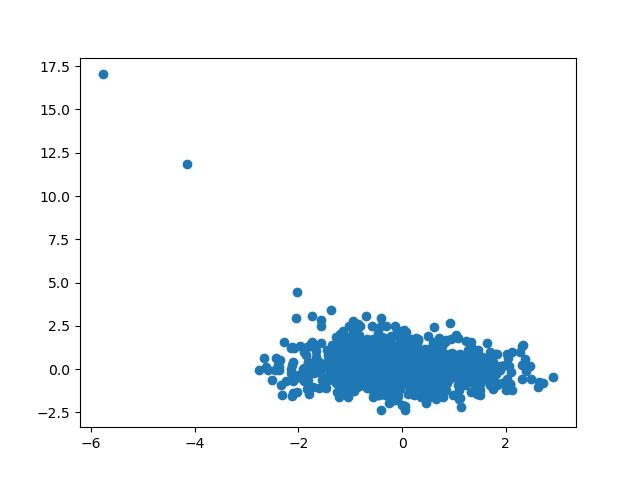

In [9]:
plt.figure()
plt.scatter(out[:,0], out[:,1])

In [10]:
test = "/share/rcifdata/jbarr/UKAEAGroupProject/data/test_data_clipped.pkl"

df_test = pd.read_pickle(test)
df_test = df_test.sample(10_000)
target = df_test['target']
df_test_good = df_test[df_test.target == 1]
df_test_good = df_test_good[train_keys]

df_test_good,_ = ScaleData(df_test_good)

df_test_bad = df_test[df_test.target == 0]
df_test_bad = df_test_bad[train_keys]
df_test_bad,_ = ScaleData(df_test_bad)

df_test_good.describe()

,ane,ate,autor,machtor,x,zeff,gammae,q,smag,alpha,ani1,ati0,normni1,ti_te0,lognustar
count,6.523000e+03,6.523000e+03,6.523000e+03,6.523000e+03,6.523000e+03,6.523000e+03,6.523000e+03,6.523000e+03,6.523000e+03,6.523000e+03,6.523000e+03,6.523000e+03,6.523000e+03,6.523000e+03,6.523000e+03
mean,2.397711e-17,1.388757e-16,6.745928e-17,-3.792255e-16,-1.740989e-16,3.463596e-16,2.694361e-16,-1.402969e-16,-1.398204e-17,2.764920e-17,-1.153199e-16,6.082569e-18,3.775065e-17,-1.201098e-15,4.799676e-18
std,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00
min,-7.629046e+00,-5.624367e+00,-1.732637e+01,-1.985693e+00,-1.416493e+00,-1.292738e+00,-2.615269e+01,-1.235186e+00,-2.112405e+00,-3.407654e+00,-7.030394e+00,-7.219967e+00,-1.746332e+00,-3.521671e+00,-2.728496e+00
25%,-4.136677e-01,-5.643995e-01,-3.169359e-01,-5.340699e-01,-9.782960e-01,-8.128132e-01,4.404597e-02,-7.432022e-01,-6.423413e-01,-4.728265e-01,-3.603364e-01,-5.585338e-01,-2.633200e-01,-9.662927e-02,-7.223513e-01
50%,-1.999981e-01,-2.559678e-01,-3.169359e-01,-5.340699e-01,-1.385592e-01,-1.552498e-01,4.404597e-02,-2.902466e-01,-3.879926e-01,-3.350481e-01,-2.085824e-01,-2.653186e-01,-2.116273e-01,-9.662927e-02,-1.477902e-01
75%,1.006726e-01,2.217515e-01,-5.886610e-02,1.736094e-01,9.246768e-01,5.289827e-01,4.404597e-02,4.569687e-01,2.416620e-01,7.892889e-02,3.350402e-02,2.773075e-01,-1.009065e-01,-9.662927e-02,6.002512e-01
max,1.289364e+01,9.666618e+00,1.942913e+01,5.515662e+00,1.655353e+00,1.307763e+01,1.209346e+01,8.307772e+00,6.278155e+00,1.396501e+01,1.415230e+01,1.003325e+01,1.964326e+01,1.817306e+01,4.558471e+00


<IPython.core.display.Javascript object>


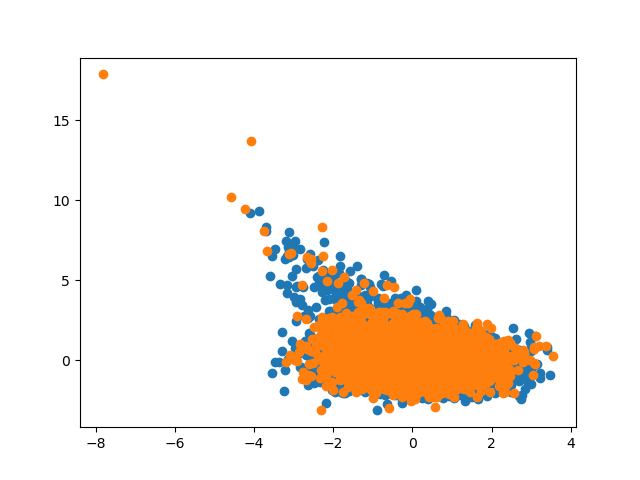

In [11]:
data_good = torch.from_numpy(df_test_good.values).float()
data_bad = torch.from_numpy(df_test_bad.values).float()
#data_good_batch = next(iter(data_good_loader))
with torch.no_grad():
    outputs_good = encoder.forward(data_good).sample()
    outputs_bad = encoder.forward(data_bad).sample()
#    outputs_good = encoder.forward(data_good).sample().detach().numpy()
    
plt.figure()
plt.scatter(outputs_good[:,0], outputs_good[:,1])
plt.scatter(outputs_bad[:,0], outputs_bad[:,1])

In [12]:
AE_output = decoder.forward(encoder.forward(data_good).sample()).sample().detach().numpy()
df_ae_output = pd.DataFrame(AE_output, columns = train_keys)
df_ae_output['AE'] = 'Outputs'

df_test_tmp = df_test_good
df_test_tmp['AE'] = 'Inputs'

In [13]:
df_compare = pd.concat([df_ae_output, df_test_tmp], ignore_index=True)
df_compare_sample = df_compare.sample(10_000)

In [38]:
for i in train_keys:
    plt.figure()
    x_min = df_compare_sample[i].quantile(0.1)
    x_max = df_compare_sample[i].quantile(0.9)
    sns.histplot(data = df_compare_sample, x = i, hue = "AE", binrange = (x_min, x_max), bins = 100);
    plt.xlabel(i)

# VAE 2

In [15]:
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()
        
 
        # encoder
        self.enc1 = nn.Linear(in_features=15, out_features = 10)
        self.enc2 = nn.Linear(in_features=10, out_features = 5)
        
        self.mu = nn.Linear(5, 2)
        self.sigma = nn.Linear(5,2)
 
        # decoder 
        self.dec1 = nn.Linear(in_features = 2, out_features = 5)
        self.dec2 = nn.Linear(in_features = 5, out_features = 10)
        self.dec3 = nn.Linear(10, 15)
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def forward(self, x):
        # encoding
        x = x.float()
        x = F.relu(self.enc1(x.float()))
        x = F.relu(self.enc2(x.float()))
        # get `mu` and `log_var`
        mu = self.mu(x) # the first feature values as mean
        log_var = self.sigma(x) # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        # decoding
        z = F.relu(self.dec1(z.float()))
        z = F.relu(self.dec2(z.float()))
        reconstruction = self.dec3(z.float())
        return reconstruction.float(), mu.float(), log_var.float()

In [57]:
batch_size = 64
lr = 0.002
epochs = 50

model = LinearVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss(reduction = "sum")

In [47]:
def final_loss(MSE_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    MSE = MSE_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [48]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        #data, _ = data
        #data = data.to(device)
        #data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        MSE_loss = criterion(reconstruction.float(), data.float())
        loss = final_loss(MSE_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [49]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(valid_data)/dataloader.batch_size)):
            #data = data.to(device)
            #data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = model(data)
            MSE_loss = criterion(reconstruction.float(), data.float())
            loss = final_loss(MSE_loss, mu, logvar)
            running_loss += loss.item()
        
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [63]:
train_data.data.describe()

,ane,ate,autor,machtor,x,zeff,gammae,q,smag,alpha,ani1,ati0,normni1,ti_te0,lognustar
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,4.242440e-18,-7.652490e-17,3.405831e-16,-4.221068e-17,-3.518408e-16,1.989298e-16,1.863652e-16,-1.844525e-16,-2.074507e-16,-4.495293e-17,1.057210e-17,2.698397e-17,-3.594000e-16,-1.534023e-16,-5.397904e-17
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00
min,-4.332893e+01,-9.769096e+00,-3.724010e+01,-2.013024e+00,-1.770964e+00,-1.284077e+00,-3.693540e-01,-1.266188e+00,-2.337054e+01,-2.413542e+01,-4.303736e+01,-3.994928e+01,-1.850044e+00,-3.069822e+00,-2.717863e+00
25%,-1.107689e-01,-3.942553e-01,-2.063781e-01,-5.771252e-01,-7.854979e-01,-7.882147e-01,-1.071987e-02,-7.196229e-01,-6.396874e-01,-3.385534e-01,-1.193723e-01,-3.814104e-01,-2.850036e-01,-1.039138e-01,-7.194893e-01
50%,-6.077309e-02,-1.915350e-01,-2.063781e-01,-5.771252e-01,4.635671e-02,-1.559265e-01,-1.071987e-02,-2.571356e-01,-3.318035e-01,-2.341794e-01,-7.605358e-02,-1.577444e-01,-2.231523e-01,-1.038521e-01,-1.575832e-01
75%,1.707666e-02,9.014109e-02,1.147768e-01,3.506374e-01,8.313612e-01,4.980725e-01,-1.071987e-02,4.318669e-01,2.831891e-01,7.122741e-02,-8.071769e-03,1.376950e-01,-3.932820e-02,-1.038521e-01,5.966363e-01
max,4.471730e+01,5.286985e+01,2.456926e+01,5.082723e+00,1.561365e+00,1.257439e+01,9.970093e+01,1.168627e+01,1.151238e+01,6.426306e+01,4.778490e+01,2.749879e+01,2.050950e+01,1.769670e+01,6.948430e+00


In [64]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, valid_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 50


10it [00:01,  6.31it/s]                      
10it [00:01,  6.26it/s]                      


Train Loss: 16.0914
Val Loss: 15.8721
Epoch 2 of 50


10it [00:01,  5.37it/s]                      
10it [00:01,  5.80it/s]                      


Train Loss: 15.7446
Val Loss: 15.6040
Epoch 3 of 50


10it [00:01,  5.76it/s]                      
10it [00:01,  6.69it/s]                      


Train Loss: 15.5349
Val Loss: 15.4426
Epoch 4 of 50


10it [00:01,  6.15it/s]                      
10it [00:01,  6.46it/s]                      


Train Loss: 15.3783
Val Loss: 15.3093
Epoch 5 of 50


10it [00:01,  6.22it/s]                      
10it [00:01,  5.77it/s]                      


Train Loss: 15.2748
Val Loss: 15.2273
Epoch 6 of 50


10it [00:01,  6.65it/s]                      
10it [00:01,  6.66it/s]                      


Train Loss: 15.1881
Val Loss: 15.1571
Epoch 7 of 50


10it [00:01,  5.73it/s]                      
10it [00:01,  5.78it/s]                      


Train Loss: 15.1312
Val Loss: 15.1141
Epoch 8 of 50


10it [00:01,  6.81it/s]                      
10it [00:01,  7.67it/s]                      


Train Loss: 15.0865
Val Loss: 15.0681
Epoch 9 of 50


10it [00:01,  5.90it/s]                      
10it [00:01,  6.55it/s]                      


Train Loss: 15.0391
Val Loss: 15.0306
Epoch 10 of 50


10it [00:01,  6.75it/s]                      
10it [00:01,  5.97it/s]                      


Train Loss: 15.0090
Val Loss: 15.0019
Epoch 11 of 50


10it [00:01,  6.15it/s]                      
10it [00:01,  5.85it/s]                      


Train Loss: 14.9694
Val Loss: 14.9749
Epoch 12 of 50


10it [00:01,  5.70it/s]                      
10it [00:01,  6.67it/s]                      


Train Loss: 14.9243
Val Loss: 14.9326
Epoch 13 of 50


10it [00:01,  6.07it/s]                      
10it [00:01,  6.06it/s]                      


Train Loss: 14.8483
Val Loss: 14.8832
Epoch 14 of 50


10it [00:01,  6.52it/s]                      
10it [00:01,  7.07it/s]                      


Train Loss: 14.7861
Val Loss: 14.8057
Epoch 15 of 50


10it [00:01,  5.83it/s]                      
10it [00:01,  5.79it/s]                      


Train Loss: 14.7023
Val Loss: 14.7460
Epoch 16 of 50


10it [00:01,  5.90it/s]                      
10it [00:01,  5.97it/s]                      


Train Loss: 14.5952
Val Loss: 14.6533
Epoch 17 of 50


10it [00:02,  4.03it/s]                      
10it [00:02,  4.18it/s]                      


Train Loss: 14.5062
Val Loss: 14.6062
Epoch 18 of 50


10it [00:02,  4.45it/s]                      
10it [00:03,  2.92it/s]                      


Train Loss: 14.4260
Val Loss: 14.5326
Epoch 19 of 50


10it [00:03,  2.86it/s]                      
10it [00:03,  2.93it/s]                      


Train Loss: 14.3184
Val Loss: 14.4412
Epoch 20 of 50


10it [00:03,  2.84it/s]                      
10it [00:03,  2.81it/s]                      


Train Loss: 14.2536
Val Loss: 14.3845
Epoch 21 of 50


10it [00:03,  2.83it/s]                      
10it [00:03,  2.90it/s]                      


Train Loss: 14.1986
Val Loss: 14.3300
Epoch 22 of 50


10it [00:03,  2.85it/s]                      
10it [00:03,  2.95it/s]                      


Train Loss: 14.0779
Val Loss: 14.2631
Epoch 23 of 50


10it [00:03,  2.83it/s]                      
10it [00:03,  2.92it/s]                      


Train Loss: 13.9845
Val Loss: 14.2028
Epoch 24 of 50


10it [00:03,  2.85it/s]                      
10it [00:02,  3.44it/s]                      


Train Loss: 13.8953
Val Loss: 14.1451
Epoch 25 of 50


10it [00:03,  3.14it/s]                      
10it [00:03,  2.95it/s]                      


Train Loss: 13.8360
Val Loss: 14.0862
Epoch 26 of 50


10it [00:03,  3.02it/s]                      
10it [00:01,  5.83it/s]                      


Train Loss: 13.7545
Val Loss: 14.0565
Epoch 27 of 50


10it [00:03,  3.12it/s]                      
10it [00:03,  2.94it/s]                      


Train Loss: 13.7106
Val Loss: 14.0179
Epoch 28 of 50


10it [00:02,  3.67it/s]                      
10it [00:03,  2.56it/s]                      


Train Loss: 13.6415
Val Loss: 13.9376
Epoch 29 of 50


10it [00:03,  3.01it/s]                      
10it [00:04,  2.36it/s]                      


Train Loss: 13.5597
Val Loss: 13.8942
Epoch 30 of 50


10it [00:03,  2.52it/s]                      
10it [00:03,  2.73it/s]                      


Train Loss: 13.5023
Val Loss: 13.8331
Epoch 31 of 50


10it [00:02,  3.40it/s]                      
10it [00:01,  5.82it/s]                      


Train Loss: 13.4226
Val Loss: 13.7794
Epoch 32 of 50


10it [00:01,  5.74it/s]                      
10it [00:01,  5.93it/s]                      


Train Loss: 13.3616
Val Loss: 13.7206
Epoch 33 of 50


10it [00:01,  5.75it/s]                      
10it [00:01,  5.72it/s]                      


Train Loss: 13.2687
Val Loss: 13.6666
Epoch 34 of 50


10it [00:01,  5.89it/s]                      
10it [00:01,  9.41it/s]                      


Train Loss: 13.2072
Val Loss: 13.6269
Epoch 35 of 50


10it [00:01,  7.61it/s]                      
10it [00:01,  5.83it/s]                      


Train Loss: 13.1599
Val Loss: 13.5813
Epoch 36 of 50


10it [00:01,  5.88it/s]                      
10it [00:01,  6.05it/s]                      


Train Loss: 13.0963
Val Loss: 13.5534
Epoch 37 of 50


10it [00:01,  6.04it/s]                      
10it [00:01,  6.04it/s]                      


Train Loss: 13.0992
Val Loss: 13.5423
Epoch 38 of 50


10it [00:01,  6.88it/s]                      
10it [00:01,  6.70it/s]                      


Train Loss: 13.0604
Val Loss: 13.5140
Epoch 39 of 50


10it [00:01,  6.35it/s]                      
10it [00:01,  7.41it/s]                      


Train Loss: 13.0071
Val Loss: 13.5082
Epoch 40 of 50


10it [00:01,  9.29it/s]                      
10it [00:01,  6.01it/s]                      


Train Loss: 13.0097
Val Loss: 13.5091
Epoch 41 of 50


10it [00:01,  5.86it/s]                      
10it [00:01,  6.06it/s]                      


Train Loss: 12.9803
Val Loss: 13.4797
Epoch 42 of 50


10it [00:01,  6.09it/s]                      
10it [00:01,  5.59it/s]                      


Train Loss: 12.9475
Val Loss: 13.4497
Epoch 43 of 50


10it [00:01,  7.06it/s]                      
10it [00:01,  8.85it/s]                      


Train Loss: 12.9345
Val Loss: 13.4296
Epoch 44 of 50


10it [00:01,  6.14it/s]                      
10it [00:01,  5.80it/s]                      


Train Loss: 12.9035
Val Loss: 13.4157
Epoch 45 of 50


10it [00:01,  5.77it/s]                      
10it [00:01,  6.12it/s]                      


Train Loss: 12.8680
Val Loss: 13.4037
Epoch 46 of 50


10it [00:01,  5.89it/s]                      
10it [00:01,  5.85it/s]                      


Train Loss: 12.8298
Val Loss: 13.3880
Epoch 47 of 50


10it [00:01,  6.30it/s]                      
10it [00:01,  5.77it/s]                      


Train Loss: 12.8014
Val Loss: 13.3586
Epoch 48 of 50


10it [00:01,  5.74it/s]                      
10it [00:01,  6.37it/s]                      


Train Loss: 12.7479
Val Loss: 13.3588
Epoch 49 of 50


10it [00:01,  5.63it/s]                      
10it [00:01,  5.83it/s]                      


Train Loss: 12.6732
Val Loss: 13.3021
Epoch 50 of 50


10it [00:01,  5.71it/s]                      
10it [00:01,  6.09it/s]                      

Train Loss: 12.6401
Val Loss: 13.2884


In [53]:
AE_output2,_,_ = model(data_good)
AE_output2 = AE_output2.detach().numpy()
df_ae_output2 = pd.DataFrame(AE_output2, columns = train_keys)
df_ae_output2['AE'] = 'Outputs'

df_compare2 = pd.concat([df_ae_output2, df_test_tmp], ignore_index=True)
df_compare_sample2= df_compare2.sample(10_000)

<IPython.core.display.Javascript object>


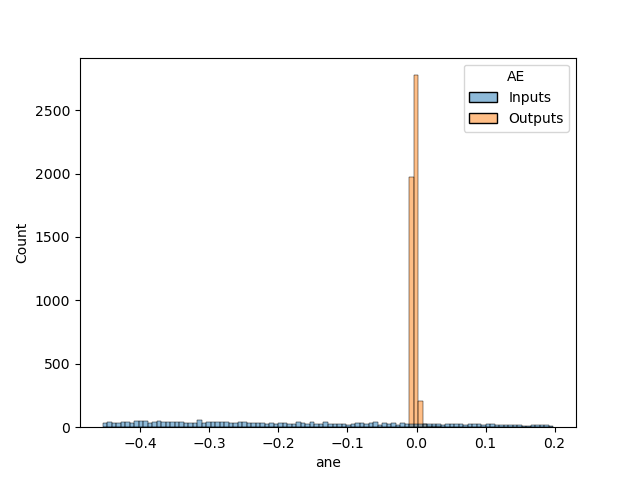

<IPython.core.display.Javascript object>


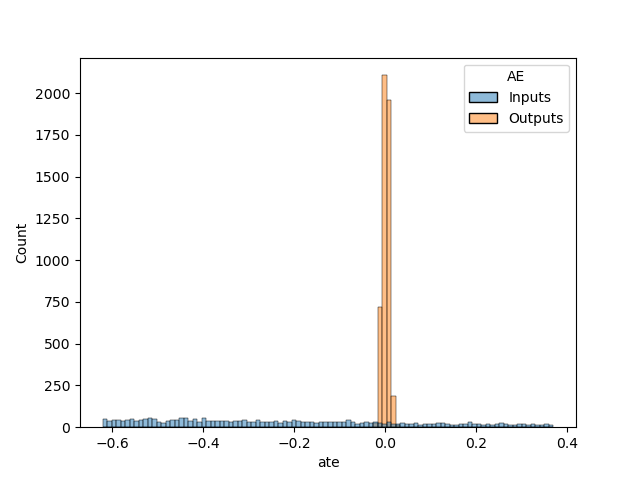

<IPython.core.display.Javascript object>


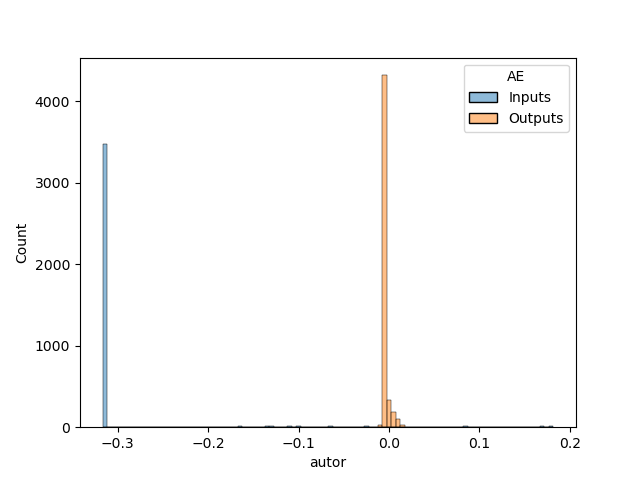

<IPython.core.display.Javascript object>


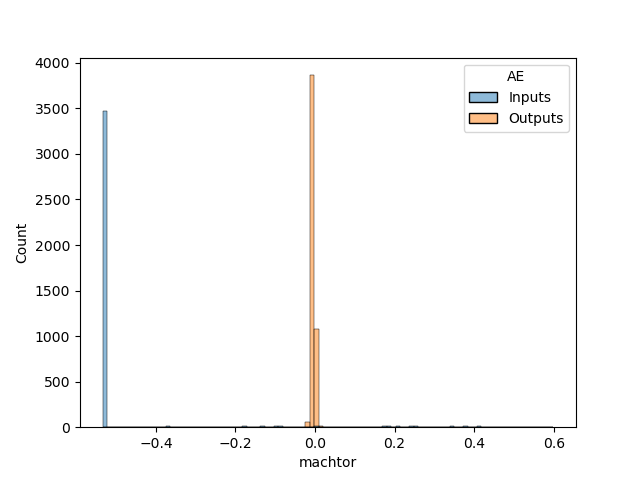

<IPython.core.display.Javascript object>


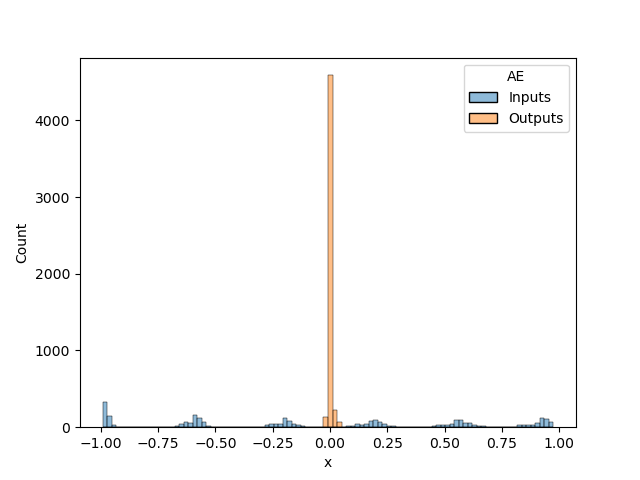

<IPython.core.display.Javascript object>


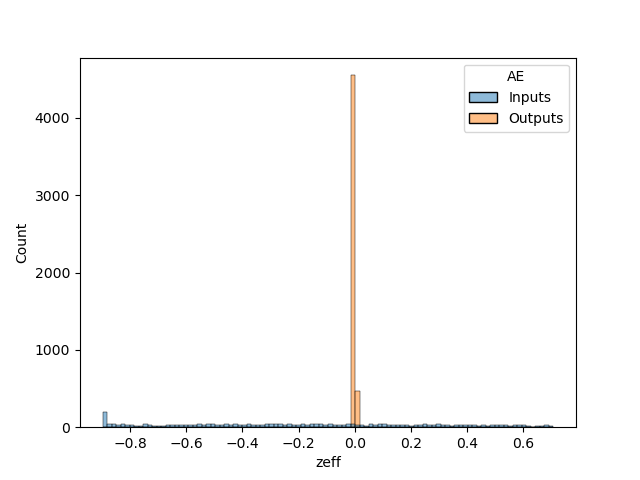

<IPython.core.display.Javascript object>


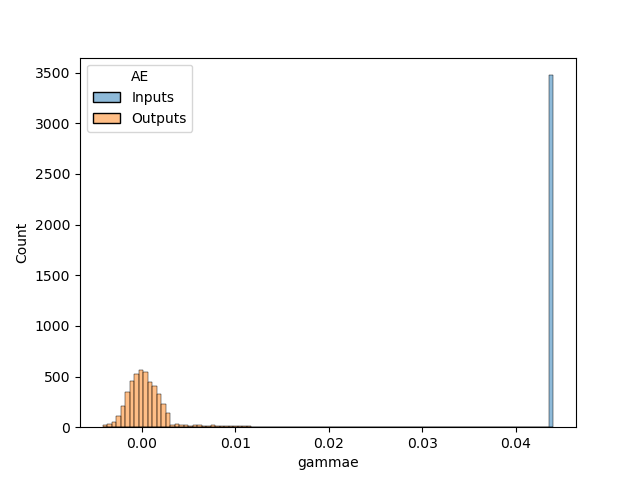

<IPython.core.display.Javascript object>


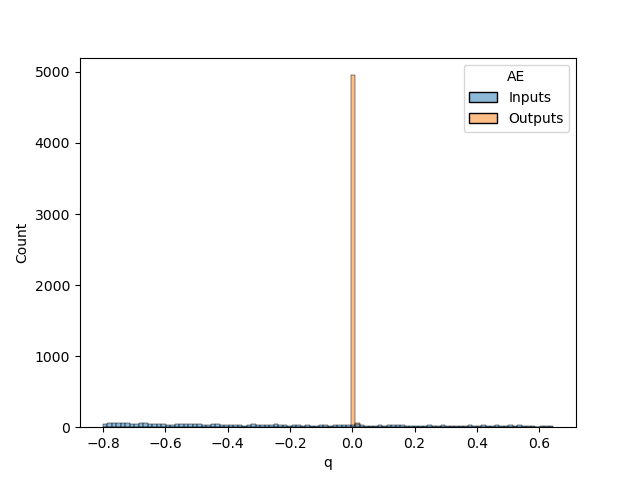

<IPython.core.display.Javascript object>


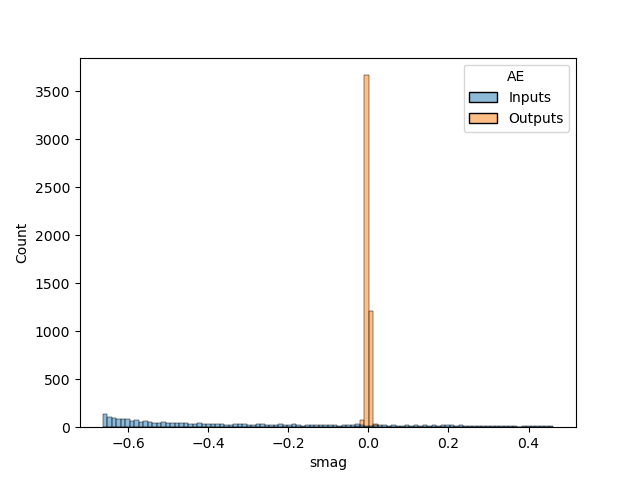

<IPython.core.display.Javascript object>


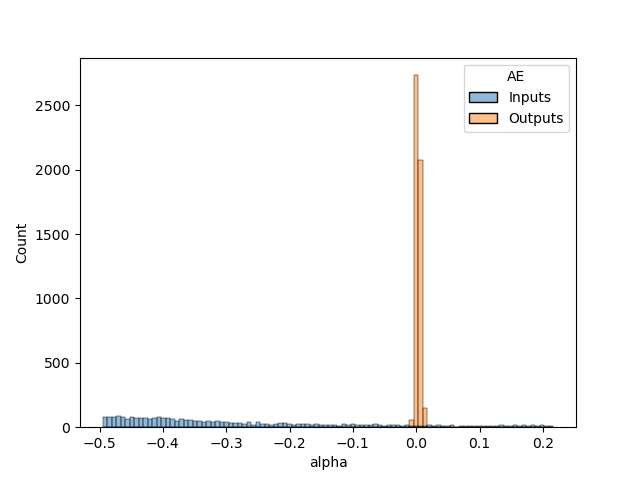

<IPython.core.display.Javascript object>


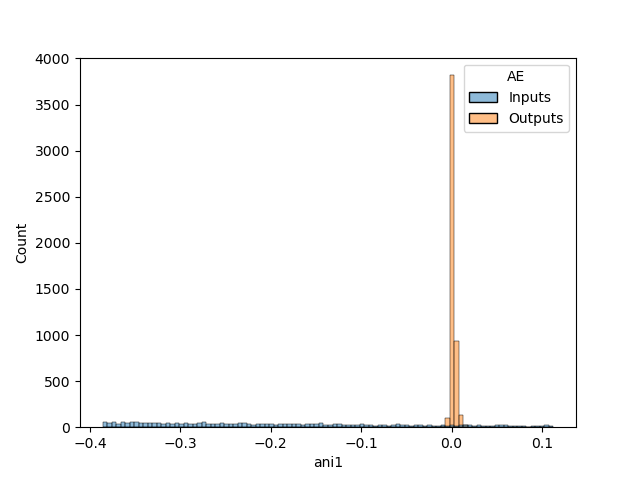

<IPython.core.display.Javascript object>


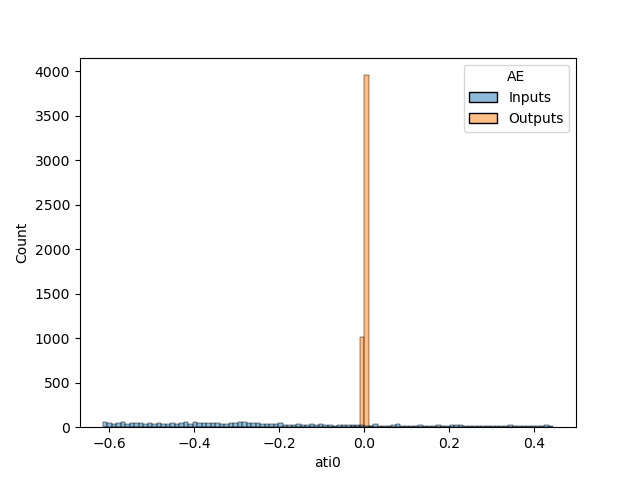

<IPython.core.display.Javascript object>


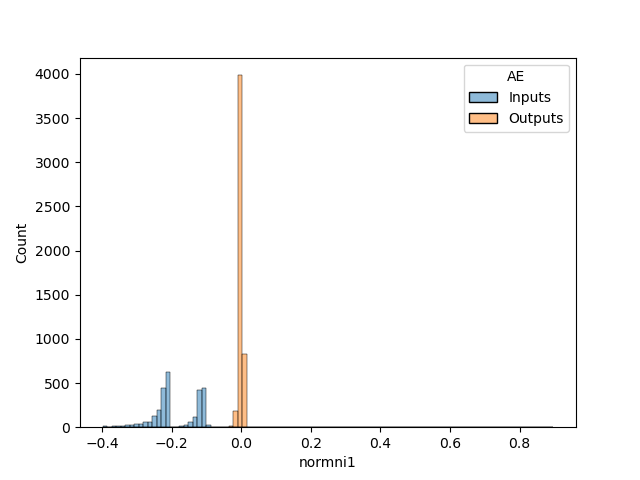

<IPython.core.display.Javascript object>


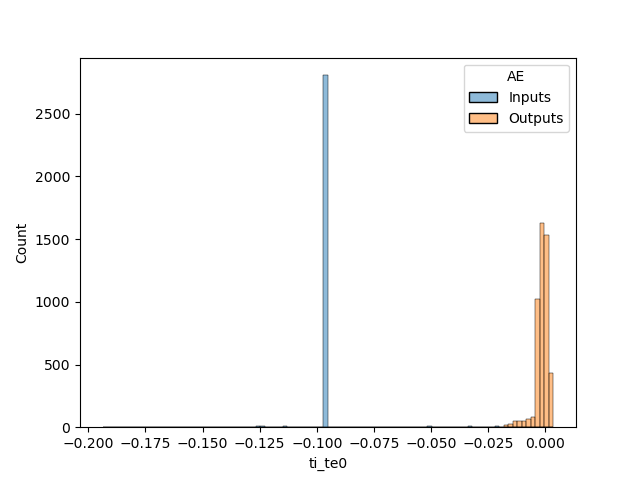

<IPython.core.display.Javascript object>


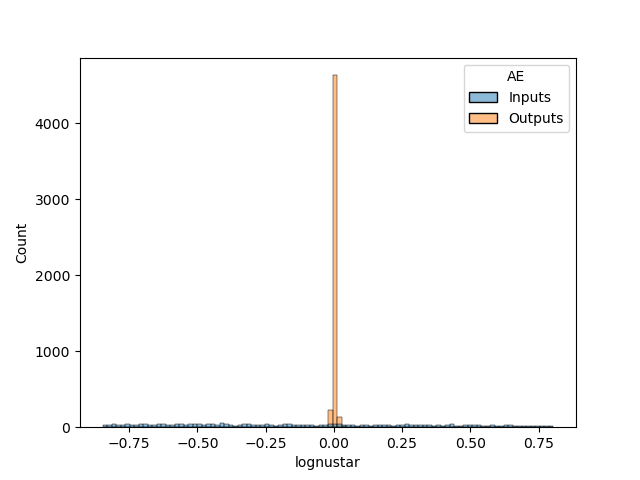

In [54]:
for i in train_keys:
    plt.figure()
    x_min = df_compare_sample2[i].quantile(0.1)
    x_max = df_compare_sample2[i].quantile(0.9)
    sns.histplot(data = df_compare_sample2, x = i, hue = "AE", binrange = (x_min, x_max), bins = 100);
    plt.xlabel(i)